In [1]:
from itertools import *
import warnings
import copy
import sys

import numpy as np
import random

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import defaultdict

import os
import argparse
import pickle



import torch
from torch import nn

from torch.nn import functional as F
from sklearn.cluster import KMeans

#from .utils import dec2bin, dec2base, base2dec

In [2]:
v = 16
f=1/4
m_2=int(f*v)
m_3=int(f*v**2)
s_2=2
s_3=3
L=2
seed_rules=0
n=v
fac=1000
num_features = v
h=512

In [3]:
def sample_mixed_rules(v, n, m_2, m_3, s_2, s_3, L, seed):
    random.seed(seed)

    # Define a callable for the inner defaultdict to return empty tensors
    def tensor_default():
        return torch.empty(0)

    tuples_2 = list(product(*[range(v) for _ in range(s_2)]))
    tuples_3 = list(product(*[range(v) for _ in range(s_3)]))

    # Define the nested defaultdict structure
    rules = defaultdict(lambda: defaultdict(tensor_default))

    # Initialize the grammar with sampled tensors
    rules[0][0] = torch.tensor(random.sample(tuples_2, n * m_2)).reshape(n, m_2, s_2)
    rules[0][1] = torch.tensor(random.sample(tuples_3, n * m_3)).reshape(n, m_3, s_3)
    for i in range(1, L):
        rules[i][0] = torch.tensor(random.sample(tuples_2, v * m_2)).reshape(
            v, m_2, s_2
        )
        rules[i][1] = torch.tensor(random.sample(tuples_3, v * m_3)).reshape(
            v, m_3, s_3
        )

    return rules

def index_to_choice_d_5(index, n,m2,m3):
    Pmax=n*m2*m3*m2
    if index <Pmax:

        bases = [n, m2,m3,m2]  # Alternating base sizes
        #index -= 1  # Convert to 0-based index
        choice = []

        # Compute the total number of possibilities
        total_combinations = 1
        for base in bases:
            total_combinations *= base

        # Extract choices one by one
        for base in bases:
            total_combinations //= base  # Reduce divisor dynamically
            choice.append(index // total_combinations + 1)
            index %= total_combinations  # Reduce index to the remainder
    else:
        index = index-Pmax
        bases = [n, m2,m2,m3]
        choice = []

        # Compute the total number of possibilities
        total_combinations = 1
        for base in bases:
            total_combinations *= base

        # Extract choices one by one
        for base in bases:
            total_combinations //= base  # Reduce divisor dynamically
            choice.append(index // total_combinations + 1)
            index %= total_combinations  # Reduce index to the remainder
    return choice

def sample_data_from_indices_d_5(
    samples, rules, n, m_2, m_3
):
    L = len(rules)
    Pmax=n*m_2*m_3*m_2
    all_features = []
    labels = []
    #samples = samples + 1
    for sample in samples:
        chosen_rules = index_to_choice_d_5(sample, n, m_2, m_3)
        labels.append(chosen_rules[0] - 1)
        # print(chosen_rules[0])
        chosen_rules = [x - 1 for x in chosen_rules]
        # for label in labels:
        # Initialize the current symbols with the start symbol
        current_symbols = [chosen_rules[0]]

        # Sequentially apply rules for each layer
        k = 0
        k_2 = 1
        if sample <Pmax:
            rule_types = [0, 1, 0]
        else:
            rule_types = [0, 0, 1]
        
        for layer in range(0, L):  # 1 to 3 (3 layers)
            new_symbols = []
            for symbol in current_symbols:
                rule_type = rule_types[k]
                k = k + 1
                # print(rule_type)
                rule_tensor = rules[layer][rule_type]
                # chosen_rule=torch.randint(low=0,high=rule_tensor.shape[1],size=(1,)).item()
                chosen_rule = chosen_rules[k_2]
                k_2 = k_2 + 1
                new_symbols.extend(rule_tensor[symbol, chosen_rule].tolist())
            # print(new_symbols)
            # new_symbols=new_symbols[0]
            # print(new_symbols)
            if new_symbols != []:
                current_symbols = new_symbols
            features = torch.tensor(new_symbols)
        all_features.append(features)
    concatenated_features = torch.cat(all_features).reshape(len(labels), -1)
    labels = torch.tensor(labels)
    return concatenated_features, labels

In [4]:
def triplets_to_num(xi, n):
    """
    Convert one long input with n-features encoding to n^3 triplet encoding.
    """
    ln = len(xi)
    xin = torch.zeros(ln // 3)
    for ii, xii in enumerate(xi):
        xin[ii // 3] += xii * n ** (2 - ii % 3)
    return xin


def tripling_features(x, n):
    """
    Batch of inputs from n to n^3 encoding using triplets.
    """
    xn = torch.zeros(x.shape[0], x.shape[-1] // 3)
    for i, xi in enumerate(x.squeeze()):
        xn[i] = triplets_to_num(xi, n)
    return xn






def encode_base_v(xi, v):
    """
    Encode a list of digits in base-v to a single integer.
    Most significant digit first.
    """
    encoded = 0
    for i, digit in enumerate(reversed(xi)):
        encoded += digit * (v ** i)
    return encoded

def triplet_pairing_features_T1(x, v):
    """
    Convert inputs of shape [N, 5] into [N, 2] where:
        - output[:, 0] encodes x[:, :3] as base-v triplet -> int in [0, v^3-1]
        - output[:, 1] encodes x[:, 3:5] as base-v pair   -> int in [0, v^2-1]
    """
    N = x.shape[0]
    x_out = torch.zeros(N, 2, dtype=torch.long)

    for i in range(N):
        triplet = x[i, :3]
        pair = x[i, 3:5]
        x_out[i, 0] = encode_base_v(triplet, v)
        x_out[i, 1] = encode_base_v(pair, v)

    return x_out


def triplet_pairing_features_T2(x, v):
    """
    Convert inputs of shape [N, 5] into [N, 2] where:
        - output[:, 0] encodes x[:, :3] as base-v triplet -> int in [0, v^3-1]
        - output[:, 1] encodes x[:, 3:5] as base-v pair   -> int in [0, v^2-1]
    """
    N = x.shape[0]
    x_out = torch.zeros(N, 2, dtype=torch.long)

    for i in range(N):
        triplet = x[i, 2:5]
        pair = x[i, :2]
        x_out[i, 0] = encode_base_v(pair, v)
        x_out[i, 1] = encode_base_v(triplet, v)

    return x_out



def pairs_to_num(xi, n):

    """
        Convert one long input with n-features encoding to n^2 pairs encoding.
    """
    ln = len(xi)
    xin = torch.zeros(ln // 2)
    for ii, xii in enumerate(xi):
        xin[ii // 2] += xii * n ** (1 - ii % 2)
    return xin

def pairing_features(x, n):
    """
        Batch of inputs from n to n^2 encoding.
    """
    xn = torch.zeros(x.shape[0], x.shape[-1] // 2)
    for i, xi in enumerate(x.squeeze()):
        xn[i] = pairs_to_num(xi, n)
    return xn

def two_layers(w1, seed, x, y):
    h, v2 = w1.size()
    assert v2 == x.shape[-1], "Input dim. not matching!"
    v = int(v2 ** .5)

    g = torch.Generator()
    g.manual_seed(seed)
    w2 = torch.randn(v, h, generator=g)

    o = (w2 @ (w1 @ x.t()).div(v2 ** .5).relu() / h).t()

    loss = torch.nn.functional.cross_entropy(o, y, reduction="mean")

    return loss, o

In [5]:
def train_model_T1(features, labels, mask,fac,h,seed_net):
    x = features[mask]
    y = labels[mask]
    x_pair = triplet_pairing_features_T1(x, v)
    x0 = F.one_hot(x_pair[:, 0], num_classes=v ** 3).float()
    x1 = F.one_hot(x_pair[:, 1], num_classes=v ** 2).float()
    
    w0 = torch.ones(h, v ** 3, requires_grad=True)
    loss0, _ = two_layers(w0, seed_net, x0, y)
    loss0.backward()
    grad0 = w0.grad.clone()

    w1 = torch.ones(h, v ** 2, requires_grad=True)
    loss1, _ = two_layers(w1, seed_net, x1, y)
    loss1.backward()
    grad1 = w1.grad.clone()
    
    with torch.no_grad():
        ws0 = nn.Parameter(w0 - grad0)
        ws1 = nn.Parameter(w1 - grad1)

    kms0 = KMeans(n_clusters=v, n_init=10).fit(ws0.t().detach().numpy())
    kms1 = KMeans(n_clusters=v, n_init=10).fit(ws1.t().detach().numpy())
    
    labels_0 = torch.tensor(kms0.labels_)[triplet_pairing_features_T1(features, v).int()[:, 0]]
    labels_1 = torch.tensor(kms1.labels_)[triplet_pairing_features_T1(features, v).int()[:, 1]]
    combined = torch.stack([labels_0, labels_1], dim=1)
    
    x = pairing_features(combined.numpy(), v)
    x = F.one_hot(x.long(), num_classes=v ** 2).float().permute(0, 2, 1)
    
    w_top = nn.Parameter(torch.ones(h, v ** 2))
    loss, o = two_layers(w_top, seed_net + 1, x[..., 0], labels)
    loss.backward()
    with torch.no_grad():
        w_top -= fac * h * w_top.grad
        loss, o = two_layers(w_top, seed_net + 1, x[..., 0], labels)
    
    per_datum_loss = F.cross_entropy(o, labels, reduction="none")
    return per_datum_loss,w_top,kms0,kms1


In [6]:
def train_model_T2(features, labels, mask,fac,h,seed_net):
    x = features[mask]
    y = labels[mask]
    x_pair = triplet_pairing_features_T2(x, v)
    x0 = F.one_hot(x_pair[:, 0], num_classes=v ** 2).float()
    x1 = F.one_hot(x_pair[:, 1], num_classes=v ** 3).float()
    
    w0 = torch.ones(h, v ** 2, requires_grad=True)
    loss0, _ = two_layers(w0, seed_net, x0, y)
    loss0.backward()
    grad0 = w0.grad.clone()

    w1 = torch.ones(h, v ** 3, requires_grad=True)
    loss1, _ = two_layers(w1, seed_net, x1, y)
    loss1.backward()
    grad1 = w1.grad.clone()
    
    with torch.no_grad():
        ws0 = nn.Parameter(w0 - grad0)
        ws1 = nn.Parameter(w1 - grad1)

    kms0 = KMeans(n_clusters=v, n_init=10).fit(ws0.t().detach().numpy())
    kms1 = KMeans(n_clusters=v, n_init=10).fit(ws1.t().detach().numpy())
    
    labels_0 = torch.tensor(kms0.labels_)[triplet_pairing_features_T2(features, v).int()[:, 0]]
    labels_1 = torch.tensor(kms1.labels_)[triplet_pairing_features_T2(features, v).int()[:, 1]]
    combined = torch.stack([labels_0, labels_1], dim=1)
    
    x = pairing_features(combined.numpy(), v)
    x = F.one_hot(x.long(), num_classes=v ** 2).float().permute(0, 2, 1)
    
    w_top = nn.Parameter(torch.ones(h, v ** 2))
    loss, o = two_layers(w_top, seed_net + 1, x[..., 0], labels)
    loss.backward()
    with torch.no_grad():
        w_top -= fac * h * w_top.grad
        loss, o = two_layers(w_top, seed_net + 1, x[..., 0], labels)
    
    per_datum_loss = F.cross_entropy(o, labels, reduction="none")
    return per_datum_loss,w_top,kms0,kms1


In [7]:
def evaluate_combined_model(features_test, labels_test, 
                            kms0_T1, kms1_T1, w_top_T1,
                            kms0_T2, kms1_T2, w_top_T2,
                            seed_net, v):
    l = 1
    y = labels_test
    
    def get_logits(features_test, kms0, kms1, ws_top, triplet_fn):
        labels_0 = torch.tensor(kms0.labels_)[triplet_fn(features_test, v).int()[:, 0]]
        labels_1 = torch.tensor(kms1.labels_)[triplet_fn(features_test, v).int()[:, 1]]
        combined = torch.stack([labels_0, labels_1], dim=1)
        x = pairing_features(combined.numpy(), v)
        x = F.one_hot(x.long(), num_classes=v ** 2).float().permute(0, 2, 1).squeeze(-1)
        with torch.no_grad():
            _, logits = two_layers(ws_top, seed_net + l, x, y)
        return logits

    # Get logits for both models
    logits_T1 = get_logits(features_test, kms0_T1, kms1_T1, w_top_T1, triplet_pairing_features_T1)
    logits_T2 = get_logits(features_test, kms0_T2, kms1_T2, w_top_T2, triplet_pairing_features_T2)

    # Softmax + confidence
    probs_T1 = F.softmax(logits_T1, dim=1)
    probs_T2 = F.softmax(logits_T2, dim=1)
    conf_T1, preds_T1 = torch.max(probs_T1, dim=1)
    conf_T2, preds_T2 = torch.max(probs_T2, dim=1)

    # Choose most confident prediction
    use_T1 = conf_T1 > conf_T2
    final_preds = torch.where(use_T1, preds_T1, preds_T2)

    # Compute test error
    test_error = (final_preds != y).float().mean().item()
    return test_error


In [8]:
import numpy as np
from collections import defaultdict

PP = np.logspace(np.log10(100), np.log10(32000), num=8, dtype=int)
results = defaultdict(list)

num_realizations = 5

for P in PP:
    print(f"\n========= Running for P = {P} =========")

    vanilla_errors = []
    single_step_errors = []
    final_errors = []
    best_errors = []
    best_error_iters = []
    num_iters = []

    for realization in range(num_realizations):
        print(f"  -- Realization {realization + 1} --")

        # === Sample Data and Rules ===
        max_data = v * m_2**2 * m_3
        train_size = P
        test_size = 1000

        samples = torch.tensor(random.sample(range(2 * max_data), train_size))
        samples_test = torch.tensor(random.sample(range(2 * max_data), test_size))

        seed_rules = random.randint(0, 1000000)
        rules = sample_mixed_rules(v, n, m_2, m_3, s_2, s_3, L, seed_rules)

        features, labels = sample_data_from_indices_d_5(samples, rules, n, m_2, m_3)
        features_test, labels_test = sample_data_from_indices_d_5(samples_test, rules, n, m_2, m_3)

        # === Initial assignments: all data used by both models ===
        N = len(features)
        assign_T1 = torch.ones(N, dtype=torch.bool)
        assign_T2 = torch.ones(N, dtype=torch.bool)

        # === Vanilla model (iteration 0) ===
        seed_net = random.randint(0, 1000000)
        losses_T1, w_top_T1, kms0_T1, kms1_T1 = train_model_T1(features, labels, assign_T1, fac, h, seed_net)
        losses_T2, w_top_T2, kms0_T2, kms1_T2 = train_model_T2(features, labels, assign_T2, fac, h, seed_net)

        vanilla_test_error = evaluate_combined_model(
            features_test, labels_test,
            kms0_T1, kms1_T1, w_top_T1,
            kms0_T2, kms1_T2, w_top_T2,
            seed_net, v
        )
        print(f"    Vanilla test error: {vanilla_test_error:.4f}")

        # === EM Iterations ===
        max_iters = 10
        best_test_error = vanilla_test_error
        best_iter = 0
        final_test_error = None
        single_step_test_error = None

        for iteration in range(1, max_iters + 1):
            losses_T1, w_top_T1, kms0_T1, kms1_T1 = train_model_T1(features, labels, assign_T1, fac, h, seed_net)
            losses_T2, w_top_T2, kms0_T2, kms1_T2 = train_model_T2(features, labels, assign_T2, fac, h, seed_net)

            new_assign_T1 = losses_T1 < losses_T2
            new_assign_T2 = ~new_assign_T1

            current_test_error = evaluate_combined_model(
                features_test, labels_test,
                kms0_T1, kms1_T1, w_top_T1,
                kms0_T2, kms1_T2, w_top_T2,
                seed_net, v
            )

            if iteration == 1:
                single_step_test_error = current_test_error

            if current_test_error < best_test_error:
                best_test_error = current_test_error
                best_iter = iteration

            if torch.equal(assign_T1, new_assign_T1):
                final_test_error = current_test_error
                break

            assign_T1 = new_assign_T1
            assign_T2 = new_assign_T2

        if final_test_error is None:
            final_test_error = current_test_error

        print(f"    Final test error after {iteration} EM iterations: {final_test_error:.4f}")
        print(f"    Best test error {best_test_error:.4f} at iteration {best_iter}")
        print(f"    Single-step test error: {single_step_test_error:.4f}")

        # === Save per-realization results ===
        vanilla_errors.append(vanilla_test_error)
        single_step_errors.append(single_step_test_error)
        final_errors.append(final_test_error)
        best_errors.append(best_test_error)
        best_error_iters.append(best_iter)
        num_iters.append(iteration)

    # === Average over 5 runs ===
    results["P"].append(P)
    results["vanilla_error"].append(np.mean(vanilla_errors))
    results["single_step_error"].append(np.mean(single_step_errors))
    results["final_error"].append(np.mean(final_errors))
    results["best_error"].append(np.mean(best_errors))
    results["best_error_iter"].append(np.mean(best_error_iters))
    results["num_iterations"].append(np.mean(num_iters))



========= Running for P = 100 =========
  -- Realization 1 --
    Vanilla test error: 0.9190


/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  

    Final test error after 10 EM iterations: 0.9290
    Best test error 0.9190 at iteration 0
    Single-step test error: 0.9190
  -- Realization 2 --
    Vanilla test error: 0.9410


/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (16). Possibly due to duplicate points in X.


    Final test error after 4 EM iterations: 0.9040
    Best test error 0.9040 at iteration 4
    Single-step test error: 0.9420
  -- Realization 3 --
    Vanilla test error: 0.9310


/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (16). Possibly due to duplicate points in X.


    Final test error after 4 EM iterations: 0.9140
    Best test error 0.9120 at iteration 3
    Single-step test error: 0.9320
  -- Realization 4 --
    Vanilla test error: 0.9350


/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (16). Possibly due to duplicate points in X.


    Final test error after 5 EM iterations: 0.9350
    Best test error 0.9060 at iteration 2
    Single-step test error: 0.9350
  -- Realization 5 --
    Vanilla test error: 0.9120


/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (16). Possibly due to duplicate points in X.


    Final test error after 3 EM iterations: 0.9330
    Best test error 0.9050 at iteration 1
    Single-step test error: 0.9050

========= Running for P = 227 =========
  -- Realization 1 --
    Vanilla test error: 0.8920
    Final test error after 10 EM iterations: 0.8860
    Best test error 0.8840 at iteration 5
    Single-step test error: 0.9020
  -- Realization 2 --
    Vanilla test error: 0.9070


/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


    Final test error after 10 EM iterations: 0.9080
    Best test error 0.9010 at iteration 3
    Single-step test error: 0.9070
  -- Realization 3 --
    Vanilla test error: 0.9010
    Final test error after 10 EM iterations: 0.9100
    Best test error 0.9010 at iteration 0
    Single-step test error: 0.9040
  -- Realization 4 --
    Vanilla test error: 0.8850
    Final test error after 10 EM iterations: 0.8880
    Best test error 0.8850 at iteration 0
    Single-step test error: 0.8850
  -- Realization 5 --
    Vanilla test error: 0.9230
    Final test error after 10 EM iterations: 0.9060
    Best test error 0.9010 at iteration 6
    Single-step test error: 0.9270

========= Running for P = 519 =========
  -- Realization 1 --
    Vanilla test error: 0.8680
    Final test error after 10 EM iterations: 0.8510
    Best test error 0.8510 at iteration 10
    Single-step test error: 0.8760
  -- Realization 2 --
    Vanilla test error: 0.8560
    Final test error after 10 EM iterations: 0.8

In [10]:
results_f_14 = copy.deepcopy(results)

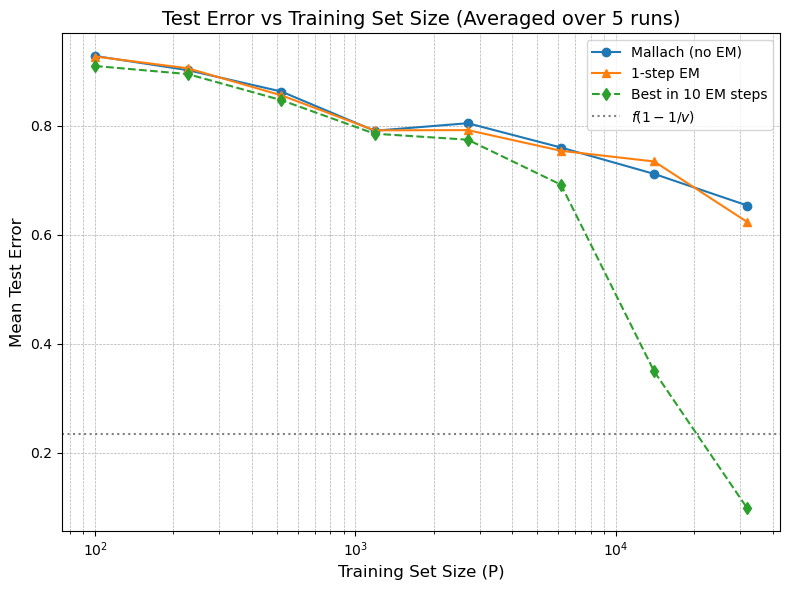

In [9]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot each type of test error
plt.plot(results["P"], results["vanilla_error"], marker='o', label='Mallach (no EM)')
plt.plot(results["P"], results["single_step_error"], marker='^', label='1-step EM')
#plt.plot(results["P"], results["final_error"], marker='s', label='Final (after EM)')
plt.plot(results["P"], results["best_error"], marker='d', linestyle='--', label='Best in 10 EM steps')
plt.axhline(y=f*(1-1/v), color='gray', linestyle=':', label='$f(1-1/v)$')
plt.xscale("log")
plt.xlabel("Training Set Size (P)", fontsize=12)
plt.ylabel("Mean Test Error", fontsize=12)
plt.title("Test Error vs Training Set Size (Averaged over 5 runs)", fontsize=14)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [14]:
import numpy as np
from collections import defaultdict
import random

PP = np.logspace(np.log10(100), np.log10(31000), num=8, dtype=int)
results = defaultdict(list)
#PP=[31000]
num_realizations = 10

for P in PP:
    print(f"\n========= Running for P = {P} =========")

    vanilla_errors = []
    single_step_errors = []
    final_errors = []
    best_errors = []
    best_error_iters = []
    num_iters = []

    for realization in range(num_realizations):
        print(f"  -- Realization {realization + 1} --")

        # === Sample Data and Rules ===
        max_data = v * m_2**2 * m_3
        train_size = P
        test_size = 1000
        import torch


        # Create the full pool of available indices
        full_range = list(range(2 * max_data))

        # Sample training indices first
        samples = random.sample(full_range, train_size)

        # Remove training indices from the pool to avoid overlap
        remaining_pool = list(set(full_range) - set(samples))

        # Sample test indices from the remaining pool
        samples_test = random.sample(remaining_pool, test_size)

        # Convert to torch tensors
        samples = torch.tensor(samples)
        samples_test = torch.tensor(samples_test)

        #samples = torch.tensor(random.sample(range(2 * max_data), train_size))
        #samples_test = torch.tensor(random.sample(range(2 * max_data), test_size))

        seed_rules = random.randint(0, 1000000)
        rules = sample_mixed_rules(v, n, m_2, m_3, s_2, s_3, L, seed_rules)

        features, labels = sample_data_from_indices_d_5(samples, rules, n, m_2, m_3)
        features_test, labels_test = sample_data_from_indices_d_5(samples_test, rules, n, m_2, m_3)

        # === Initial assignments: all data used by both models ===
        N = len(features)
        assign_T1 = torch.ones(N, dtype=torch.bool)
        assign_T2 = torch.ones(N, dtype=torch.bool)

        # === Vanilla model (iteration 0) ===
        seed_net = random.randint(0, 1000000)
        losses_T1, w_top_T1, kms0_T1, kms1_T1 = train_model_T1(features, labels, assign_T1, fac, h, seed_net)
        losses_T2, w_top_T2, kms0_T2, kms1_T2 = train_model_T2(features, labels, assign_T2, fac, h, seed_net)

        vanilla_test_error = evaluate_combined_model(
            features_test, labels_test,
            kms0_T1, kms1_T1, w_top_T1,
            kms0_T2, kms1_T2, w_top_T2,
            seed_net, v
        )
        print(f"    Vanilla test error: {vanilla_test_error:.4f}")

        # === EM Iterations ===
        max_iters = 10
        best_test_error = vanilla_test_error
        best_iter = 0
        final_test_error = None
        single_step_test_error = None

        for iteration in range(1, max_iters + 1):
            losses_T1, w_top_T1, kms0_T1, kms1_T1 = train_model_T1(features, labels, assign_T1, fac, h, seed_net)
            losses_T2, w_top_T2, kms0_T2, kms1_T2 = train_model_T2(features, labels, assign_T2, fac, h, seed_net)

            new_assign_T1 = losses_T1 < losses_T2
            new_assign_T2 = ~new_assign_T1

            current_test_error = evaluate_combined_model(
                features_test, labels_test,
                kms0_T1, kms1_T1, w_top_T1,
                kms0_T2, kms1_T2, w_top_T2,
                seed_net, v
            )

            if iteration == 1:
                single_step_test_error = current_test_error

            if current_test_error < best_test_error:
                best_test_error = current_test_error
                best_iter = iteration

            if torch.equal(assign_T1, new_assign_T1):
                final_test_error = current_test_error
                break

            assign_T1 = new_assign_T1
            assign_T2 = new_assign_T2

        if final_test_error is None:
            final_test_error = current_test_error

        print(f"    Final test error after {iteration} EM iterations: {final_test_error:.4f}")
        print(f"    Best test error {best_test_error:.4f} at iteration {best_iter}")
        print(f"    Single-step test error: {single_step_test_error:.4f}")

        # === Save per-realization results ===
        vanilla_errors.append(vanilla_test_error)
        single_step_errors.append(single_step_test_error)
        final_errors.append(final_test_error)
        best_errors.append(best_test_error)
        best_error_iters.append(best_iter)
        num_iters.append(iteration)

    # === Average over 5 runs ===
    results["P"].append(P)
    results["vanilla_error"].append(np.mean(vanilla_errors))
    results["single_step_error"].append(np.mean(single_step_errors))
    results["final_error"].append(np.mean(final_errors))
    results["best_error"].append(np.mean(best_errors))
    results["best_error_iter"].append(np.mean(best_error_iters))
    results["num_iterations"].append(np.mean(num_iters))



========= Running for P = 100 =========
  -- Realization 1 --
    Vanilla test error: 0.9400


/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  

    Final test error after 10 EM iterations: 0.9380
    Best test error 0.9310 at iteration 2
    Single-step test error: 0.9400
  -- Realization 2 --
    Vanilla test error: 0.9410


/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


    Final test error after 2 EM iterations: 0.9330
    Best test error 0.9330 at iteration 2
    Single-step test error: 0.9420
  -- Realization 3 --
    Vanilla test error: 0.9500


/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.


    Final test error after 10 EM iterations: 0.9410
    Best test error 0.9340 at iteration 3
    Single-step test error: 0.9490
  -- Realization 4 --
    Vanilla test error: 0.9400


/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (16). Possibly due to duplicate points in X.


    Final test error after 10 EM iterations: 0.9340
    Best test error 0.9300 at iteration 3
    Single-step test error: 0.9390
  -- Realization 5 --
    Vanilla test error: 0.9330


/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (16). Possibly due to duplicate points in X.


    Final test error after 10 EM iterations: 0.9400
    Best test error 0.9230 at iteration 3
    Single-step test error: 0.9300
  -- Realization 6 --
    Vanilla test error: 0.9290


/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (16). Possibly due to duplicate points in X.


    Final test error after 3 EM iterations: 0.9240
    Best test error 0.9180 at iteration 2
    Single-step test error: 0.9310
  -- Realization 7 --
    Vanilla test error: 0.9230


/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.


    Final test error after 5 EM iterations: 0.9160
    Best test error 0.9140 at iteration 4
    Single-step test error: 0.9180
  -- Realization 8 --
    Vanilla test error: 0.9270


/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (16). Possibly due to duplicate points in X.


    Final test error after 10 EM iterations: 0.9260
    Best test error 0.9260 at iteration 4
    Single-step test error: 0.9270
  -- Realization 9 --
    Vanilla test error: 0.9380


/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (16). Possibly due to duplicate points in X.


    Final test error after 4 EM iterations: 0.9190
    Best test error 0.9190 at iteration 4
    Single-step test error: 0.9390
  -- Realization 10 --
    Vanilla test error: 0.9180


/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/parley/miniconda3/envs/nlp2/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.


    Final test error after 6 EM iterations: 0.9300
    Best test error 0.9180 at iteration 0
    Single-step test error: 0.9190

========= Running for P = 226 =========
  -- Realization 1 --
    Vanilla test error: 0.9100
    Final test error after 10 EM iterations: 0.9200
    Best test error 0.9060 at iteration 3
    Single-step test error: 0.9140
  -- Realization 2 --
    Vanilla test error: 0.9200
    Final test error after 10 EM iterations: 0.9080
    Best test error 0.9000 at iteration 6
    Single-step test error: 0.9230
  -- Realization 3 --
    Vanilla test error: 0.9180
    Final test error after 5 EM iterations: 0.9270
    Best test error 0.9100 at iteration 3
    Single-step test error: 0.9180
  -- Realization 4 --
    Vanilla test error: 0.9160


KeyboardInterrupt: 